### This notebook is created to evaluate multiple models with ensemble learning.

- You can add the ensemble models in "ensemble _models" folder
- Because the size of models are too big, they did not push to the Github. The ensemble models are sent by email
- Adding these models to the given folder is enough to run this code
- The GWDH 2021 data can be downloaded by the following link: https://www.kaggle.com/datasets/cetinkayaevren/gwdh-2021 
- You can add the given dataset to the "data(2021)" folder 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image, ImageDraw
import os
import numpy as np

# Model
import ultralytics
from ultralytics import YOLO
from ultralytics.utils.ops import non_max_suppression
import torch
ultralytics.checks()

from ensemble_boxes import weighted_boxes_fusion

#Test Result Saving
from comet_ml import ExistingExperiment

Ultralytics YOLOv8.2.52  Python-3.10.14 torch-2.3.0 CUDA:0 (NVIDIA GeForce GTX 1050, 4096MiB)
Setup complete  (12 CPUs, 15.9 GB RAM, 236.4/237.9 GB disk)


### Get Models

In [3]:
trained_model_1 = YOLO('ensemble_models\\yolov8n\\model.pt')
trained_model_2 = YOLO('ensemble_models\\yolov8s\\model.pt')
trained_model_3 = YOLO('ensemble_models\\yolov8m\\model.pt')
trained_model_4 = YOLO('ensemble_models\\yolov8l\\model.pt')

### Get Testing Dataset

In [4]:
project_path = os.getcwd()
test_data_path = 'data(2021)\\gwhd_2021\\test\\images'
test_total_path = os.path.join(project_path, test_data_path)

In [5]:
test_df = pd.read_csv("data(2021)\\gwhd_2021\\competition_test.csv") 

In [6]:
test_df.head()

image_name  \
0  255b6ca9fea63f44125e5174bc932470b604c760430715...   
1  7f5eb37cab658de6fd0d688bf27f16e423794fed6184d8...   
2  7bcfff43b356f4a94948367782aa704a37ff4579baf45d...   
3  e535384eda9d0f9c6ac57dd9397d5d614e4cad48c144d8...   
4  66e9fa7379fd7b7fd64024ac1b03b8e56f9ad020c10635...   

                                         BoxesString domain  
0  481 820 604 922;655 957 732 1024;930 926 1013 ...   UQ_7  
1  896 911 977 955;800 898 821 941;770 867 804 90...   UQ_7  
2  892 993 922 1024;844 943 871 965;758 926 801 9...   UQ_7  
3  648 886 722 1024;392 950 507 1024;876 677 981 ...   UQ_7  
4  559 939 623 1009;775 875 829 919;853 883 888 9...   UQ_7

In [7]:
#import cv2  #For visualizing

def ensemble_predict(models, image):
    all_predictions = []
    # Collect predictions from each model
    for i,model in enumerate(models):
        preds = model(image)  # Get predictions
        
        all_predictions.append(preds[0].boxes)  # Assuming batch size is 1
    

    combined_predictions = combine_predictions(all_predictions)
    
    return combined_predictions

def combine_predictions(all_predictions):
    all_predictions_wbf_normalized = [pred.xyxyn for pred in all_predictions]
    all_scores_wbf_list = [pred.conf for pred in all_predictions]
    all_classes_wbf_list = [pred.cls for pred in all_predictions]

    iou_thr = 0.5
    skip_box_thr = 0.0001
    final_threshold = 0.25 # TODO: try with 0.25, default = 1e-3
    
    
    # Apply Weight-Boxes-Fusion (WBF)
    boxes, scores, labels = weighted_boxes_fusion(all_predictions_wbf_normalized, all_scores_wbf_list, all_classes_wbf_list, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    final_scores_ids = np.where(scores > final_threshold)[0]
 
    final_boxes = boxes[final_scores_ids]
 
    # Box coordinates in [xmin, ymin, xmax, ymax] in de-normalized form.
    final_boxes = (final_boxes*1024).clip(min=[0.,0.,0.,0.],
                                            max=[1023, 1023, 1023, 1023])

    final_boxes = final_boxes.astype("int")

    return final_boxes


In [8]:
# List of trained models
models = [trained_model_1, trained_model_2, trained_model_3, trained_model_4]

predictions_dict = {}
for sample_path in test_df["image_name"]:
    sample_abs_path = os.path.join(test_total_path, sample_path)
    # Make ensemble prediction
    ensemble_predictions = ensemble_predict(models, sample_abs_path)
    predictions_dict[sample_path] = ensemble_predictions

c:\Users\evren\anaconda3\envs\app_proj\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


image 1/1 c:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021\test\images\255b6ca9fea63f44125e5174bc932470b604c76043071522ba0ef63abb1a544b.png: 1024x1024 48 wheat_heads, 35.0ms
Speed: 7.0ms preprocess, 35.0ms inference, 123.2ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021\test\images\255b6ca9fea63f44125e5174bc932470b604c76043071522ba0ef63abb1a544b.png: 1024x1024 51 wheat_heads, 81.0ms
Speed: 8.0ms preprocess, 81.0ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021\test\images\255b6ca9fea63f44125e5174bc932470b604c76043071522ba0ef63abb1a544b.png: 1024x1024 53 wheat_heads, 166.7ms
Speed: 6.0ms preprocess, 166.7ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021\tes

### Sample Visualization (Optional)


image 1/1 c:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021\test\images\255b6ca9fea63f44125e5174bc932470b604c76043071522ba0ef63abb1a544b.png: 1024x1024 48 wheat_heads, 139.0ms
Speed: 278.6ms preprocess, 139.0ms inference, 3.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021\test\images\255b6ca9fea63f44125e5174bc932470b604c76043071522ba0ef63abb1a544b.png: 1024x1024 51 wheat_heads, 82.8ms
Speed: 7.0ms preprocess, 82.8ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021\test\images\255b6ca9fea63f44125e5174bc932470b604c76043071522ba0ef63abb1a544b.png: 1024x1024 53 wheat_heads, 185.0ms
Speed: 11.0ms preprocess, 185.0ms inference, 3.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021

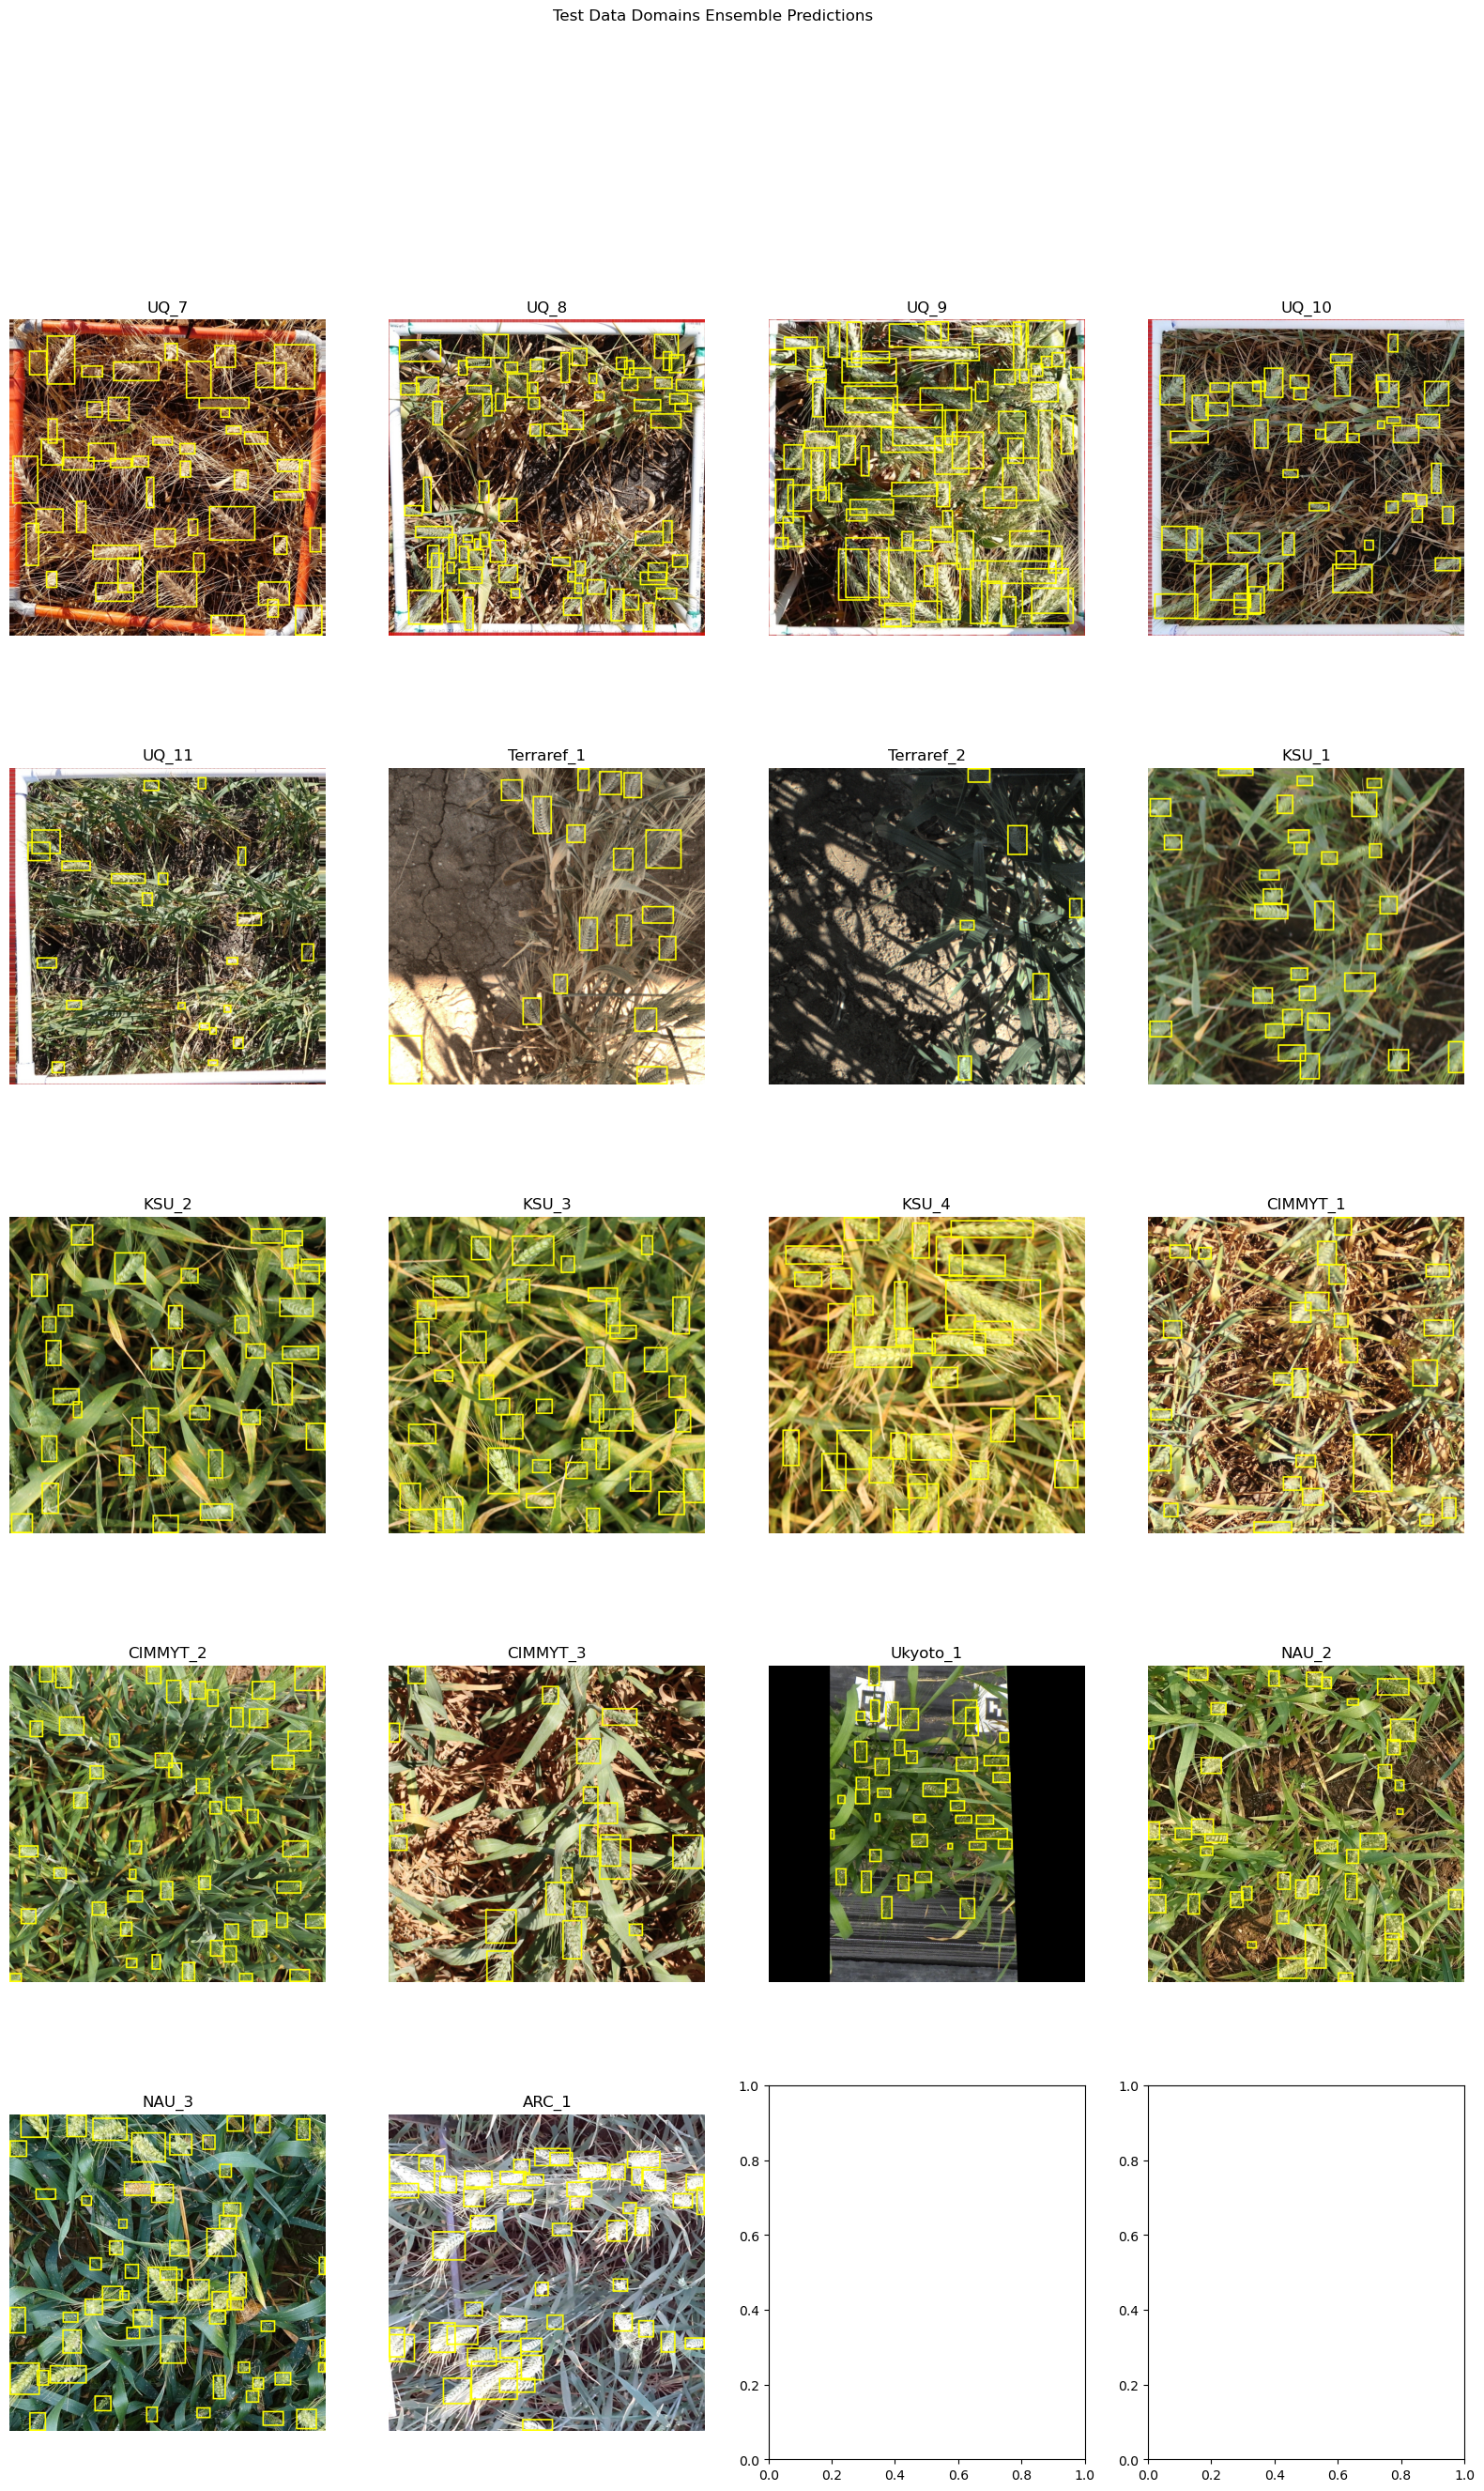

In [9]:

domain_list = iter(test_df["domain"].unique())
fig, axs = plt.subplots(5, 4, figsize=(20, 30))

for rows in range(axs.shape[0]):
    for cols in range(axs.shape[1]):
        for region in domain_list:
            iloc = 0
            if region == "Terraref_1" or region == "CIMMYT_3": #Because no bounding box for the first images of these 
                iloc = 4
            
            sample = test_df[test_df["domain"] == region].iloc[iloc]
            abs_path = test_data_path + "\\" +sample["image_name"]
            with Image.open(abs_path) as im:
                draw = ImageDraw.Draw(im)
                ensemble_predictions = ensemble_predict(models, abs_path)

                for loc in ensemble_predictions:
                    xy = [(loc[0], loc[1]),(loc[2], loc[3])]
                    draw.rectangle(xy=xy, outline ="yellow", width=5)
                axs[rows][cols].imshow(im)
                axs[rows][cols].axis("off")
                axs[rows][cols].title.set_text(region) 
            break
plt.suptitle('Test Data Domains Ensemble Predictions') # or plt.suptitle('Main title')
plt.show()

### Collecting Ground Truths in a dictionary

In [10]:
gt_dictionary = {}
for idx, img in test_df.iterrows():
    boxes_list = img["BoxesString"].split(";")
    labels_list = []
    for box in boxes_list:
        xyxy = box.split(" ")
        labels_list.append(xyxy)
    gt_dictionary[img["image_name"]] = labels_list

### Calculating IoU custom Functions

In [11]:
# Function to calculate IoU (Intersection over Union)
def calculate_iou(box1, box2):
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])

    inter_area = max(0, x2_min - x1_max) * max(0, y2_min - y1_max)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area
    return iou

### Getting TP, FP, FN values for each Image

In [12]:
def evaluate(predictions, ground_truths, iou_threshold=0.5): #Calculates TP, FP, FN for each image with the IoU threshold 0.5
    TP, FP, FN = 0, 0, 0
    matched_gt_indices = set()
    for pred_box in predictions:
        match_found = False
        for i, gt_box in enumerate(ground_truths):
            if gt_box == "no_box":
                FP = len(pred_box)
                TP = 0
                FN = 0
                return TP, FP, FN
            gt_box = list(map(int, gt_box))
            if i not in matched_gt_indices:
                iou = calculate_iou(pred_box, gt_box)
                if iou >= iou_threshold:
                    TP += 1
                    matched_gt_indices.add(i)
                    match_found = True
                    break
        if not match_found:
            FP += 1

    FN = len(ground_truths) - len(matched_gt_indices)
    return TP, FP, FN


### Calculation Based on Domain-Specific Approach

In [13]:
#Store total accuracy and number of samples based on their domains in dictionary
keys = test_df["domain"].unique()
default_val = 0
domain_total_acc = dict.fromkeys(keys, default_val)
domain_sample_count = dict.fromkeys(keys, default_val)

In [14]:
#Evaluate predicted labels with ground truth labels and extract TP, FP, FN values for each image
#Calculate the accuracy and store it to the corresponding domain in the dictionary
for idx, img in test_df.iterrows():
    gt_labels = gt_dictionary[img["image_name"]]
    predicted_labels = predictions_dict[img["image_name"]]
    if gt_labels[0][0] == "no_box":
        if len(predicted_labels)>0:
            accuracy_img = 0.
        else:
            accuracy_img = 1.
    else:
        TP, FP, FN = evaluate(predicted_labels, gt_labels)
        accuracy_img = TP/(TP + FP + FN)
    domain_total_acc[img["domain"]] += accuracy_img
    domain_sample_count[img["domain"]] += 1

In [15]:
#Calculate average for each domain
avg_domains = {k: domain_total_acc[k]/ domain_sample_count[k] for k in domain_total_acc}
print(avg_domains)

{'UQ_7': 0.79280198096467, 'UQ_8': 0.6085723314984145, 'UQ_9': 0.5951858173500305, 'UQ_10': 0.681094201246747, 'UQ_11': 0.5390679700628197, 'Terraref_1': 0.21718062699125268, 'Terraref_2': 0.19220176610126102, 'KSU_1': 0.6305645316214747, 'KSU_2': 0.5869212617270934, 'KSU_3': 0.5640992456181686, 'KSU_4': 0.4990845759225234, 'CIMMYT_1': 0.5392325870214021, 'CIMMYT_2': 0.7451602602597903, 'CIMMYT_3': 0.6985387410575056, 'Ukyoto_1': 0.5060208505021012, 'NAU_2': 0.8561699504458425, 'NAU_3': 0.8535366233903661, 'ARC_1': 0.5859861309230063}


In [16]:
#Calculate the average of all domains to get Average Domain Accuracy
average_domain_accuracy = sum(avg_domains.values()) / len(avg_domains)
print("AVERAGE DOMAIN ACCURACY FOR GWHC 2021: ", average_domain_accuracy)

AVERAGE DOMAIN ACCURACY FOR GWHC 2021:  0.5939677473724706


### Record Results to Comet ML (Optional)

In [ ]:
# OPTIONAL: Storing the evaluation results to comet.ml 

"""
test_metrics = {
   "metrics/test/avg_domain_acc": average_domain_accuracy
}

exp = ExistingExperiment(api_key="<api-key>", previous_experiment="<experiment-name>") #Add experiment ID
exp.log_metrics(test_metrics)
exp.end()
"""